In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
torch.cuda.is_available()

True

In [4]:
mean_gray = 0.1307
stddev_gray = 0.3081

In [5]:
transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (stddev_gray,))])


In [6]:
train_dataset = datasets.MNIST(root = './data', 
                            train = True, 
                            transform = transforms,
                            download = False)

test_dataset = datasets.MNIST(root = './data', 
                            train = False, 
                            transform = transforms)

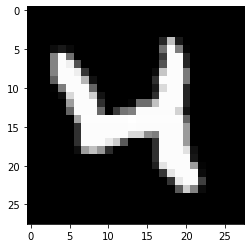

In [7]:
import matplotlib.pyplot as plt
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap='gray')

In [8]:
train_dataset[20][1]

4

![cnn mnist](https://user-images.githubusercontent.com/30661597/61713471-3c957d00-ad8b-11e9-9a38-e3f4d1e72565.png)

In [9]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)

In [10]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_load)))
print('There are {} batches in the testloader'.format(len(test_load)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 8 feature maps is 
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
        #Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)
        #RELU
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is now 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        #Output size of each of the 32 feature maps remains 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        #After max pooling, the output of each feature map is 14/2 = 7
        #Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before! 
        #It will take the shape (batch_size, 1568) = (100, 1568)
        out = out.view(-1,1568)
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [12]:
cnn = CNN()

In [13]:
cnn

CNN(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=600, bias=True)
  (droput): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=600, out_features=10, bias=True)
)

In [14]:
CUDA = torch.cuda.is_available()

In [15]:
CUDA

True

In [16]:
if CUDA:
    cnn = cnn.cuda()

In [17]:
loss_fn = nn.CrossEntropyLoss()        
# Show weight decay
optimizer = torch.optim.SGD(cnn.parameters(), lr = 0.01)

In [21]:
#Training the CNN
num_epochs = 25

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    cnn.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = cnn(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.item()         # Accumulate the loss
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Testing
    testing_loss = 0.0
    correct = 0
    iterations = 0

    cnn.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = cnn(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Epoch 1/25, Training Loss: 0.157, Training Accuracy: 95.487, Testing Loss: 0.096, Testing Acc: 97.280
Epoch 2/25, Training Loss: 0.114, Training Accuracy: 96.655, Testing Loss: 0.075, Testing Acc: 97.790
Epoch 3/25, Training Loss: 0.093, Training Accuracy: 97.335, Testing Loss: 0.065, Testing Acc: 97.960
Epoch 4/25, Training Loss: 0.081, Training Accuracy: 97.633, Testing Loss: 0.057, Testing Acc: 98.150
Epoch 5/25, Training Loss: 0.072, Training Accuracy: 97.885, Testing Loss: 0.053, Testing Acc: 98.330
Epoch 6/25, Training Loss: 0.065, Training Accuracy: 98.058, Testing Loss: 0.048, Testing Acc: 98.390
Epoch 7/25, Training Loss: 0.059, Training Accuracy: 98.290, Testing Loss: 0.045, Testing Acc: 98.480
Epoch 8/25, Training Loss: 0.054, Training Accuracy: 98.400, Testing Loss: 0.042, Testing Acc: 98.500
Epoch 9/25, Training Loss: 0.052, Training Accuracy: 98.448, Testing Loss: 0.042, Testing Acc: 98.540
Epoch 10/25, Training Loss: 0.046, Training Accuracy: 98.653, Testing Loss: 0.040,

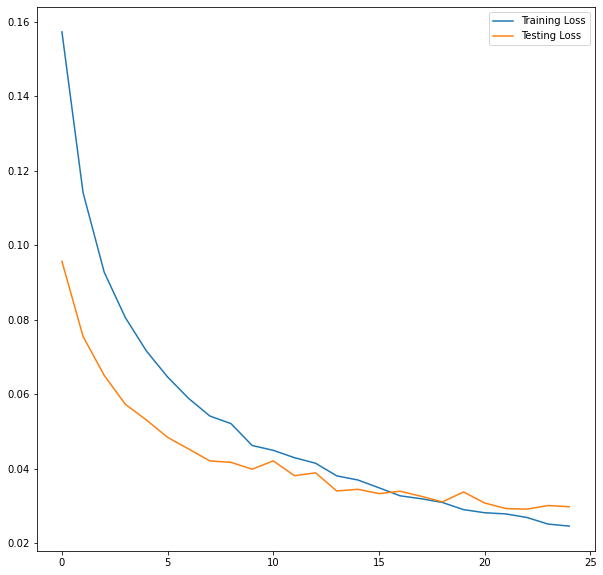

In [22]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

In [32]:
train_accuracy

[tensor(95.4867, device='cuda:0'),
 tensor(96.6550, device='cuda:0'),
 tensor(97.3350, device='cuda:0'),
 tensor(97.6333, device='cuda:0'),
 tensor(97.8850, device='cuda:0'),
 tensor(98.0583, device='cuda:0'),
 tensor(98.2900, device='cuda:0'),
 tensor(98.4000, device='cuda:0'),
 tensor(98.4483, device='cuda:0'),
 tensor(98.6533, device='cuda:0'),
 tensor(98.6683, device='cuda:0'),
 tensor(98.7467, device='cuda:0'),
 tensor(98.7617, device='cuda:0'),
 tensor(98.9067, device='cuda:0'),
 tensor(98.9700, device='cuda:0'),
 tensor(98.9567, device='cuda:0'),
 tensor(99.0033, device='cuda:0'),
 tensor(99.0917, device='cuda:0'),
 tensor(99.0667, device='cuda:0'),
 tensor(99.1033, device='cuda:0'),
 tensor(99.1750, device='cuda:0'),
 tensor(99.1717, device='cuda:0'),
 tensor(99.2267, device='cuda:0'),
 tensor(99.2333, device='cuda:0'),
 tensor(99.2883, device='cuda:0')]

In [35]:
train_accuracy2 = [t.cpu() for t in train_accuracy]
test_accuracy2 = [t.cpu() for t in test_accuracy]

In [36]:
train_accuracy2

[tensor(95.4867),
 tensor(96.6550),
 tensor(97.3350),
 tensor(97.6333),
 tensor(97.8850),
 tensor(98.0583),
 tensor(98.2900),
 tensor(98.4000),
 tensor(98.4483),
 tensor(98.6533),
 tensor(98.6683),
 tensor(98.7467),
 tensor(98.7617),
 tensor(98.9067),
 tensor(98.9700),
 tensor(98.9567),
 tensor(99.0033),
 tensor(99.0917),
 tensor(99.0667),
 tensor(99.1033),
 tensor(99.1750),
 tensor(99.1717),
 tensor(99.2267),
 tensor(99.2333),
 tensor(99.2883)]

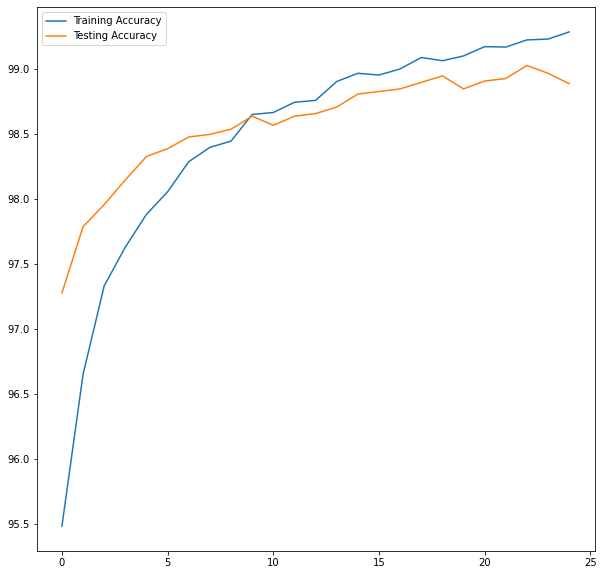

In [37]:
# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy2, label='Training Accuracy')
plt.plot(test_accuracy2, label='Testing Accuracy')
plt.legend()
plt.show()

In [41]:
img = test_dataset[30][0].resize_((1, 1, 28, 28))   #(batch_size,channels,height,width)
label = test_dataset[30][1]

cnn.eval()

if CUDA:
    cnn = cnn.cuda()
    img = img.cuda()
    
output = cnn(img)
_, predicted = torch.max(output,1)
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))

Prediction is: 3
Actual is: 3


In [43]:
mkdir models

In [44]:

torch.save(cnn.state_dict(),'models/CNN_MNIST.pth')

# Understand a few calls

In [19]:
iteration = 0
correct = 0

for i,(inputs,labels) in enumerate (train_load):

    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = cnn(inputs)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted Shape",predicted.shape)
    print("Predicted Tensor:")
    print(predicted)
    correct += (predicted == labels).sum()
    break

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([5, 5, 5, 7, 5, 5, 2, 0, 5, 4, 2, 5, 3, 7, 2, 5, 2, 7, 5, 5, 4, 5, 8, 5,
        0, 5, 0, 5, 5, 4, 7, 2, 5, 5, 7, 7, 5, 5, 4, 7, 5, 5, 2, 5, 5, 5, 5, 5,
        7, 5, 0, 5, 7, 5, 5, 7, 5, 4, 0, 5, 0, 5, 2, 2, 7, 2, 5, 7, 9, 6, 5, 0,
        5, 5, 0, 5, 7, 5, 0, 7, 7, 5, 5, 2, 2, 7, 5, 5, 5, 5, 5, 0, 0, 7, 3, 0,
        2, 1, 2, 1], device='cuda:0')
